# Reaction-Diffusion simulation using OpenPNM

OpenPNM is capable of simulating chemical reactions in pores by modeling Fickian diffusion with source and sink terms. This example shows how this problem is set up and run in OpenPNM.

In [1]:
import numpy
import openpnm
import matplotlib.pyplot as plt

numpy.set_printoptions(precision=5)
%matplotlib inline

## Create the network

We are going to be using a built-in network structure from OpenPNM. Our network consists of a regular square lattice of size `N x N` with uniform lattice spacing `l`. For now, we are using `2d` network, but you can try it in `3d` as well

In [2]:
pn = openpnm.network.Cubic(shape=[40, 40], spacing=1e-4)

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2022-03-27 11:00:18,230
------------------------------------------------------------


## Adding geometry

The OpenPNM geometry object contains information about size of the pores/throats in a network. OpenPNM has tons of prebuilt geometries that can be used to represent a variety of microstructures. We are going to use a simple geometry called `StickAndBall` that creates spherical pores, cylindrical throats, assigns random values to pore/throat diameters.

In [3]:
geo = openpnm.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)


## Adding a phase

The phase object defines the properties of the fluid used in the simulation. You can have multiple phases. For our problem we only need a single gas phase.

In [4]:
gas = openpnm.phases.Air(network=pn)

## Adding physics

A physics object contains information that depends on the network geometry. For e.g., diffusive conductance, which depends on the fluid thermophysical properties and the pore/throat geometry. OpenPNM includes a pre-defined physics class called Standard which as the name suggests contains all the standard pore-scale models.

In [5]:
phys = openpnm.physics.Standard(network=pn, geometry=geo, phase=gas)

## Setup the initial conditions and source terms

Once the physics is defined, we can update the values of the pore scale properties to setup source and sink terms. We are going to use OpenPNM's built-in power law to describe our first order reaction.

In [6]:
# Setup initial conditions
gas['pore.concentration'] = 0

# Setup sink conditions a.k.a reaction rate law r = A*(C^B)
phys['pore.sinkA'] = -1e-9
phys['pore.sinkB'] = 1
phys.add_model(propname='pore.sink', model=openpnm.models.physics.generic_source_term.power_law, 
               A1='pore.sinkA', A2='pore.sinkB', X='pore.concentration')

phys['pore.srcA'] = +1e-11
phys['pore.srcB'] = 1
phys.add_model(propname='pore.source', model=openpnm.models.physics.generic_source_term.power_law, 
                A1='pore.srcA', A2='pore.srcB', X='pore.concentration')

## Setup Fickian diffusion problem

To run any simulation, we will need to add an algorithm to run calculations on the network. In each simulation the algorithm acts on the `network` and `phase` objects, hence we will need these two to be defined before we setup our algorithm object. 

We also need to add some boundary conditions to the simulation. By default, OpenPNM assumes zero flux for the boundary pores. The `set_value_BC` function applies a `Dirichlet boundary condition` to the specified pores.

In [7]:
# Setup equation and boundary conditions
rxd = openpnm.algorithms.FickianDiffusion(network=pn)
rxd.setup(phase=gas)
rxd.set_source(propname='pore.sink', pores=[420, 820])
rxd.set_value_BC(values=1, pores=pn.pores('front'))
rxd.set_value_BC(values=1, pores=pn.pores('back'))
rxd.run()

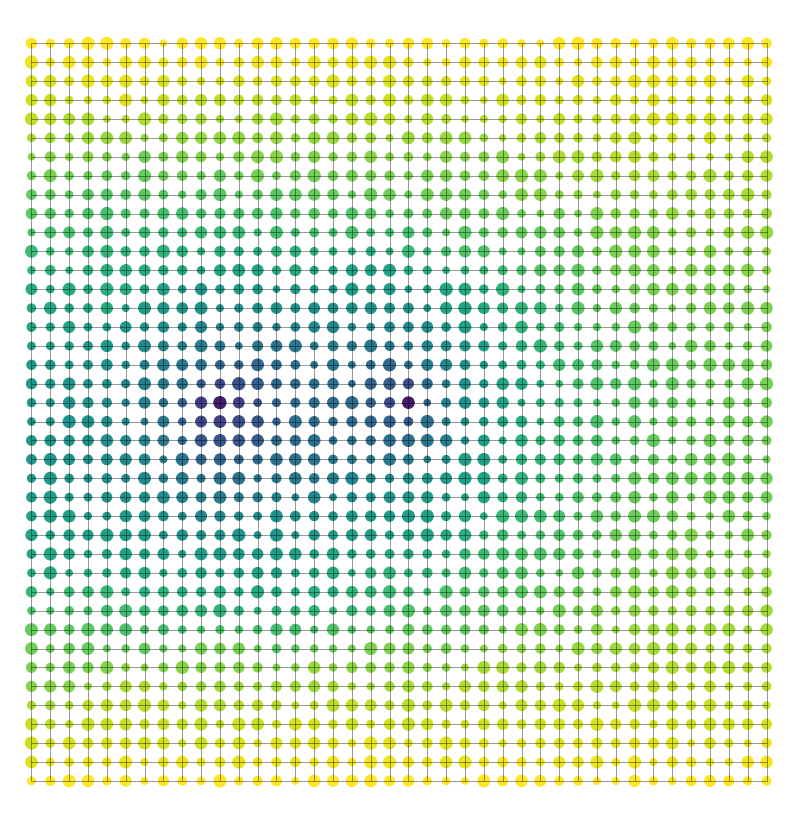

In [12]:
pn['pore.concentration'] = rxd['pore.concentration']

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot()
fig = openpnm.topotools.plot_connections(network=pn, color='k', alpha=0.4, ax=ax)
fig = openpnm.topotools.plot_coordinates(network=pn, color_by=pn['pore.concentration'],  
                                         size_by=pn['pore.diameter'], cmap='viridis', ax=ax, markersize=150)

_ = plt.axis('off')

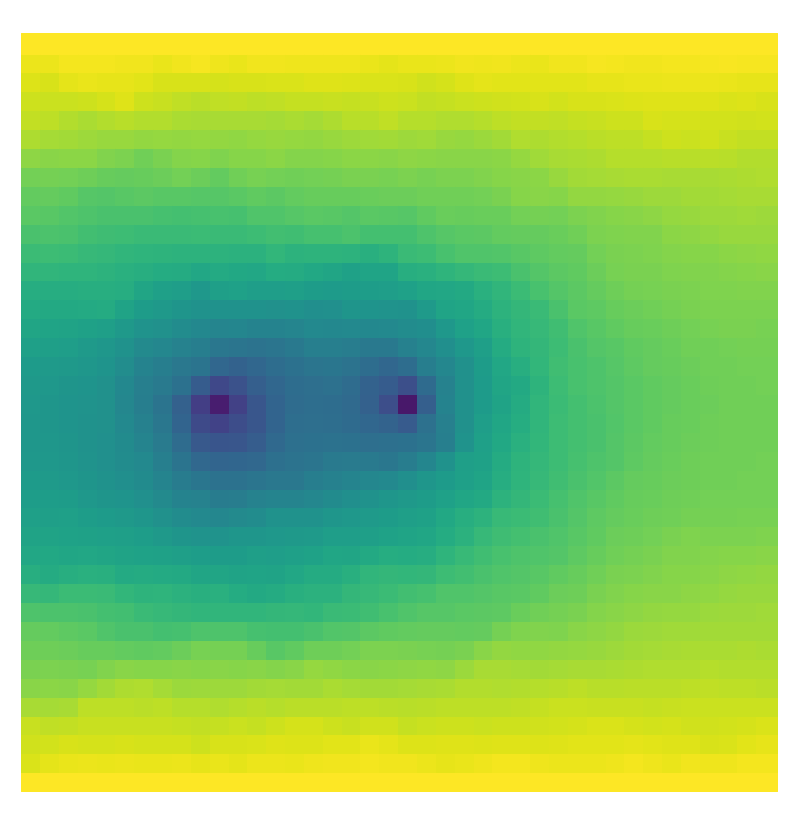

In [13]:
pn['pore.concentration'] = rxd['pore.concentration']

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot()
fig = openpnm.topotools.plot_connections(network=pn, color='k', alpha=0, ax=ax)
fig = openpnm.topotools.plot_coordinates(network=pn, color_by=pn['pore.concentration'], 
                                         cmap='viridis', ax=ax, markersize=420, marker='s')

_ = plt.axis('off')

## Reaction in all pores

In the previous example, we only had sink terms active in two of the pores. How do we implement reaction in all the pores?

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2022-03-27 11:05:54,304
------------------------------------------------------------


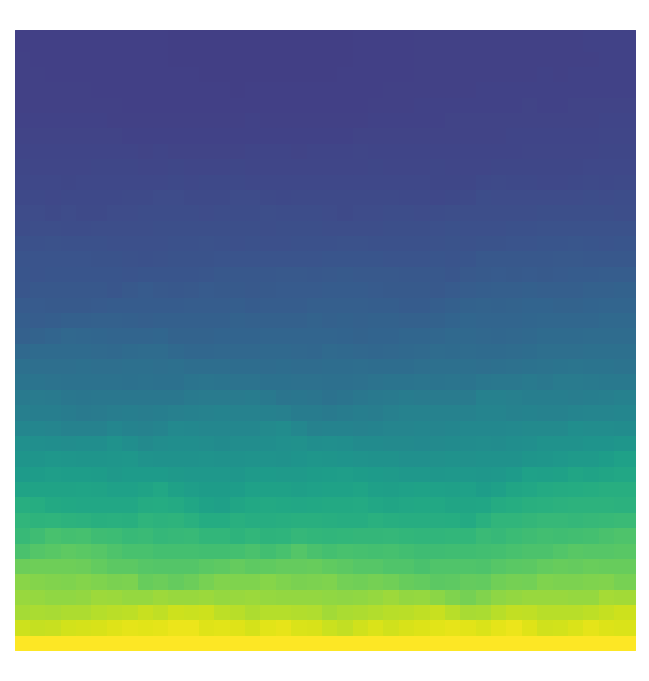

In [15]:
# Setup the network
pn = openpnm.network.Cubic(shape=[40, 40], spacing=1e-4)
geo = openpnm.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)
gas = openpnm.phases.Air(network=pn)

# Setup initial conditions
gas['pore.concentration'] = 0
gas['pore.diffusivity'] = 8e-5 # Default OpenPNM value is 2.06755e-05

# Setup physics
phys = openpnm.physics.Standard(network=pn, geometry=geo, phase=gas)

# Setup sink conditions a.k.a reaction rate law r = A*(C^B)
phys['pore.sinkA'] = -1e-12
phys['pore.sinkB'] = 1
phys.add_model(propname='pore.sink', model=openpnm.models.physics.generic_source_term.power_law, 
               A1='pore.sinkA', A2='pore.sinkB', X='pore.concentration')

# Setup equation and boundary conditions
rxda = openpnm.algorithms.FickianDiffusion(network=pn)
rxda.setup(phase=gas, solver_family='scipy')
internal_pores = list(set(pn.pores('all')) - set(pn.pores('surface')))
rxda.set_source(propname='pore.sink', pores=internal_pores)
rxda.set_value_BC(values=1, pores=pn.pores('front'))

# Run the calculation
rxda.run()

# Update network object concentrations
pn['pore.concentration'] = rxda['pore.concentration']

# Plot
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot()
fig = openpnm.topotools.plot_connections(network=pn, color='k', alpha=0, ax=ax)
fig = openpnm.topotools.plot_coordinates(network=pn, color_by=pn['pore.concentration'], 
                                         cmap='viridis', ax=ax, markersize=420, marker='s')

_ = plt.axis('off')